In [1]:
from visual_behavior.data_access import loading, utilities, from_lims
import visual_behavior.utilities as vbu
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from multiprocessing import Pool

In [5]:
df = pd.DataFrame(data={'col1': [1, 2], 'col2': [3, 4]})
fn = 'df.parquet'
df.to_parquet(fn)

## load the full stimulus table, then view details for a single experiment

In [6]:
et = loading.get_filtered_ophys_experiment_table(release_data_only=True)
et['cre_line'].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

In [7]:
oeid= et.query('cre_line == "Slc17a7-IRES2-Cre" and session_type == "OPHYS_4_images_B"').sample(random_state=0).index[0]

In [8]:
et.loc[oeid]['ophys_session_id']

973701907

In [9]:
osid = 973701907
et.query('ophys_session_id == {}'.format(osid))

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,...,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
974358971,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027825,VisualBehaviorMultiscope,179,VISp,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399772
974358967,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027822,VisualBehaviorMultiscope,73,VISp,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399659
974358969,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027831,VisualBehaviorMultiscope,371,VISp,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399697
974358975,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027834,VisualBehaviorMultiscope,83,VISl,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399613
974358977,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027844,VisualBehaviorMultiscope,355,VISl,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399646
974358973,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027828,VisualBehaviorMultiscope,261,VISp,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399428
974358979,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027837,VisualBehaviorMultiscope,181,VISl,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399727
974358981,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,484627,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,113.0,Slc17a7-IRES2-Cre,GCaMP6f,4,...,3,973701907,973744975,1018027841,VisualBehaviorMultiscope,281,VISl,2019-10-29 10:41:35.836194,OPHYS_4_images_B,1085399720


In [10]:
def get_stimulus_df_in_ophys_time(oeid):
    dataset = loading.get_ophys_dataset(oeid)
    stimulus_table = dataset.stimulus_presentations
    
    time_df = pd.DataFrame({
        'timestamps': dataset.ophys_timestamps,
        'timestamp_index': np.arange(len(dataset.ophys_timestamps))
    })
    
    time_df['onset_frame'] = False
    time_df['image_name'] = None
    time_df['image_index'] = None
    time_df['image_present'] = False
    time_df['omission'] = False
    time_df['is_change'] = False
    for idx, stimulus in stimulus_table.iterrows():
#         print('on {} of {}'.format(idx, stimulus_table.index.max()), end='\r')
        if stimulus['omitted']:
            stimulus['stop_time'] = stimulus['start_time'] + 0.250
        query_string = 'timestamps >= {} and timestamps <= {}'.format(stimulus['start_time'], stimulus['stop_time'])
        indices = time_df.query(query_string).index

        time_df.at[indices[0], 'onset_frame'] = True
        time_df.at[indices, 'image_name'] = stimulus['image_name']
        time_df.at[indices, 'image_index'] = stimulus['image_index']
        time_df.at[indices, 'image_present'] = True
        time_df.at[indices, 'omission'] = stimulus['omitted']
        time_df.at[indices, 'is_change'] = stimulus['is_change']
        
    return time_df

In [11]:
def get_df_for_experiment(oeid):
    
    dataset = loading.get_ophys_dataset(oeid)
    
    tidy_df = utilities.build_tidy_cell_df(dataset)
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        tidy_df[metadata_key] = dataset.metadata[metadata_key]

    tidy_df = tidy_df.merge(
        get_stimulus_df_in_ophys_time(oeid),
        left_on='timestamps',
        right_on='timestamps',
        how='left'
    )
    
    return tidy_df

In [12]:
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid)['ophys_experiment_id']
with Pool(8) as pool:
    session_df = pool.map(get_df_for_experiment, oeids)

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observa

In [13]:
session_df = pd.concat(session_df)

In [14]:
len(session_df['cell_specimen_id'].unique())

1135

In [16]:
len(session_df)

54864765

In [15]:
saveloc = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/tidy_data'

In [17]:
fn = 'ophys_session_id={}.parquet'.format(osid)
session_df.to_parquet(os.path.join(saveloc, fn))

In [85]:
fn = 'ophys_session_id={}.h5'.format(osid)
session_df.to_hdf(os.path.join(saveloc, fn), key='df', mode='w')

/home/dougo/anaconda3/envs/vba/lib/python3.8/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['targeted_structure', 'equipment_name', 'cre_line', 'sex', 'image_name', 'image_index']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [90]:
!pip install fastparquet

    100% |████████████████████████████████| 153kB 1.3MB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/db/83/7d4008ffc2988066ff37f6a0bb6d7b60822367dcb36ba5e39aa7801fda54/pandas-0.24.2-cp27-cp27mu-manylinux1_x86_64.whl
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 3.6MB 352kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16eaaeb20/numpy-1.16.6-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 61kB 1.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/70/94/784178ca5dd892a98f113cdd923372024dc04b8d40abe77ca76b5fb90ca6/pytz-2021.1-py2.py3-n

In [49]:
tidy_df['image_name'].unique()

array([None, 'im000', 'omitted', 'im035', 'im106', 'im073', 'im031',
       'im075', 'im054', 'im045'], dtype=object)

In [55]:
tidy_df.query('image_name == "im035"')

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,timestamp_index,onset_frame,image_name,image_index,image_present,omission,is_change
3928,374.74129,1080730001,1086512421,-0.068955,0.000000,0.000000e+00,974358969,3928,True,im035,7,True,False,True
3929,374.83452,1080730001,1086512421,0.211155,0.214939,7.148838e-02,974358969,3929,False,im035,7,True,False,True
3936,375.48715,1080730001,1086512421,-0.057113,0.000000,1.563802e-04,974358969,3936,True,im035,7,True,False,False
3937,375.58038,1080730001,1086512421,0.022676,0.000000,2.398168e-05,974358969,3937,False,im035,7,True,False,False
3944,376.23301,1080730001,1086512421,-0.046498,0.000000,4.362176e-14,974358969,3944,True,im035,7,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342189,3739.59715,1080731685,1086542408,-0.028575,0.000000,0.000000e+00,974358969,40018,False,im035,7,True,False,False
4342196,3740.24981,1080731685,1086542408,-0.001434,0.000000,0.000000e+00,974358969,40025,True,im035,7,True,False,False
4342197,3740.34304,1080731685,1086542408,0.006816,0.000000,0.000000e+00,974358969,40026,False,im035,7,True,False,False
4342204,3740.99570,1080731685,1086542408,0.036269,0.000000,0.000000e+00,974358969,40033,True,im035,7,True,False,False


## load a dataset object

In [5]:
dataset = loading.get_ophys_dataset(oeid)

## load the stimulus table

In [6]:
stimulus_table = dataset.stimulus_presentations
stimulus_table.head(10)

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time
stimulus_presentations_id,,,,,,,,,,,
0,0.25021,18001.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17986,308.57085,308.82106
1,0.25020,18046.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18031,309.32147,309.57167
2,0.25019,18091.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18076,310.07208,310.32227
3,0.25013,18136.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18121,310.82274,311.07287
4,0.25021,18181.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,False,18166,311.57326,311.82347
5,0.25021,18226.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,5,False,False,18211,312.32387,312.57408
6,0.25020,18271.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,6,False,False,18256,313.07450,313.32470
7,0.25020,18316.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,7,False,False,18301,313.82515,314.07535
8,NaN,NaN,8,omitted,omitted,0,False,True,18345,314.55904,NaN


## load a tidy dataframe of cell activity

In [33]:
tidy_df = utilities.build_tidy_cell_df(dataset)
tidy_df

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events
0,8.54249,1080730001,1086512421,0.276424,0.0,0.0
1,8.63569,1080730001,1086512421,0.477695,0.0,0.0
2,8.72890,1080730001,1086512421,0.229618,0.0,0.0
3,8.82210,1080730001,1086512421,0.008415,0.0,0.0
4,8.91531,1080730001,1086512421,-0.028617,0.0,0.0
...,...,...,...,...,...,...
4350505,4514.95184,1080731685,1086542408,0.112574,0.0,0.0
4350506,4515.04508,1080731685,1086542408,0.116418,0.0,0.0
4350507,4515.13831,1080731685,1086542408,0.100769,0.0,0.0
4350508,4515.23155,1080731685,1086542408,0.148043,0.0,0.0


In [10]:
stimulus = stimulus_table.iloc[0]
stimulus

duration                                                 0.25021
end_frame                                                  18001
image_index                                                    0
image_name                                                 im000
image_set      Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
index                                                          0
is_change                                                  False
omitted                                                    False
start_frame                                                17986
start_time                                               308.571
stop_time                                                308.821
Name: 0, dtype: object

In [21]:
time_df

,timestamps,timestamp_index,image_name,image_index,image_present,omission,is_change
0,8.54249,0,None,None,False,False,False
1,8.63569,1,None,None,False,False,False
2,8.72890,2,None,None,False,False,False
3,8.82210,3,None,None,False,False,False
4,8.91531,4,None,None,False,False,False
...,...,...,...,...,...,...,...
48334,4514.95184,48334,None,None,False,False,False
48335,4515.04508,48335,None,None,False,False,False
48336,4515.13831,48336,None,None,False,False,False
48337,4515.23155,48337,None,None,False,False,False


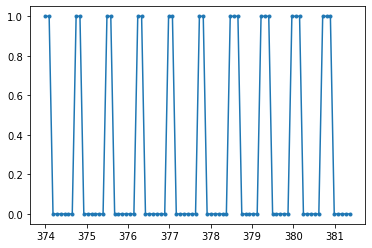

In [57]:
fig, ax = plt.subplots()
ax.plot(
    tidy_df.iloc[3920:4000]['timestamps'],
    tidy_df.iloc[3920:4000]['image_present'],
    marker='.'
)